Data from [kaggle](https://www.kaggle.com/ronitf/heart-disease-uci)

Attribute Information:

        age
        sex
        chest pain type (4 values)
        resting blood pressure
        serum cholestoral in mg/dl
        fasting blood sugar > 120 mg/dl
        resting electrocardiographic results (values 0,1,2)
        maximum heart rate achieved
        exercise induced angina
        oldpeak = ST depression induced by exercise relative to rest
        the slope of the peak exercise ST segment
        number of major vessels (0-3) colored by flourosopya
        thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [12]:
np.linspace(10, 200, 10).astype(int)

array([ 10,  31,  52,  73,  94, 115, 136, 157, 178, 200])

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [2]:
PATH_TO_DATA_RAW = "../data/raw/heart.csv"

In [3]:
df = pd.read_csv(PATH_TO_DATA_RAW)
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
target = 'target'
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [5]:
assert len(set(cat_features + num_features + [target])) == df.shape[1]
assert df[cat_features + num_features].shape[1] == df.shape[1] - 1

In [8]:
df[num_features].max()

age          77.0
trestbps    200.0
chol        564.0
thalach     202.0
oldpeak       6.2
dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


There are no NaN

<AxesSubplot:>

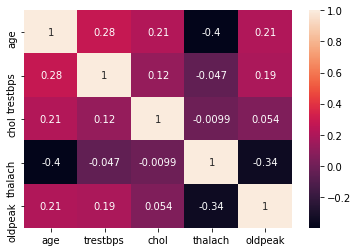

In [6]:
sns.heatmap(df[num_features].corr(), annot=True)

No big correlation

`target` on numerical features

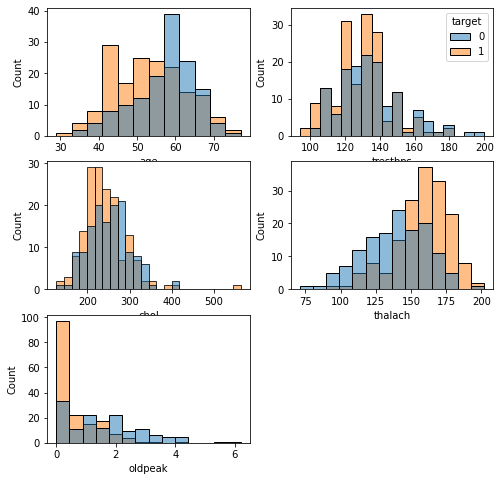

In [31]:
plt.figure(figsize=(8, 8))
for i, fea in enumerate(num_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df, x=fea, hue=target, legend=(i == 2))

In [49]:
gr = df[cat_features + [target]].groupby(target)  #.apply(pd.get_dummies)

In [53]:
cdf = gr.apply(lambda d: pd.get_dummies(
    d, columns=cat_features).sum()).drop(target, axis=1).T

In [56]:
cdf

target,0,1
sex_0,24,72
sex_1,114,93
cp_0,104,39
cp_1,9,41
cp_2,18,69
cp_3,7,16
fbs_0,116,142
fbs_1,22,23
restecg_0,79,68
restecg_1,56,96


`target` on categorical features

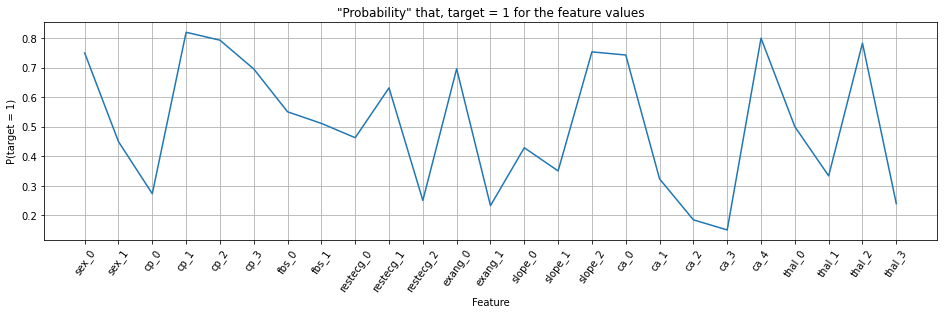

In [72]:
plt.figure(figsize=(16, 4))
(cdf[1] / cdf.sum(axis=1)).plot()
plt.xticks(np.arange(len(cdf)), cdf.index, rotation=55)
plt.grid()
plt.title('"Probability" that target = 1 for the feature values')
plt.xlabel('Feature')
plt.ylabel('P(target = 1)')
plt.show()

fast pipeline

In [156]:
X = pd.get_dummies(df.drop(target, axis=1), columns=cat_features)

In [157]:
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])
X = X.values
y = df[target].values

In [158]:
lr = LogisticRegression(random_state=55)
cv_scores = cross_val_score(lr, X, y, scoring='roc_auc', cv=5, n_jobs=-1, )

In [159]:
cv_scores.mean(), cv_scores.std()

(0.9194564694564695, 0.023667860439439595)

In [160]:
clfs = [
    LogisticRegression(C=.4),
    KNeighborsClassifier(n_neighbors=10, p=1),
    ExtraTreesClassifier(min_samples_leaf=2),
    BernoulliNB(),
    GaussianNB(var_smoothing=1e-1),
]
for clf in clfs:
    cv_scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=5, n_jobs=-1, )
    print(str(clf).split('(')[0], '\t', cv_scores.mean(), cv_scores.std())

LogisticRegression 	 0.9203463203463202 0.022695960676467238
KNeighborsClassifier 	 0.9095999679333012 0.026501011311493666
ExtraTreesClassifier 	 0.8874258457591792 0.03462628608784582
BernoulliNB 	 0.9202982202982204 0.02472681676066134
GaussianNB 	 0.9183742183742183 0.02851517324119751
